In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import astropy
from astropy.table import Table
# reference flux
s0=15
dat = Table.read('differential_sky_area.ecsv')
s= np.append(dat['detection_threshold'], 15)
fov_tot = np.append(dat['sky_area'], 1897*175)
counts = np.zeros_like(s)
counts[-1] = 1

# This is the notebook where I use the NUTS sampler for the mixture model for the purpose of model comparison

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ur, u, g, alpha]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 94 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


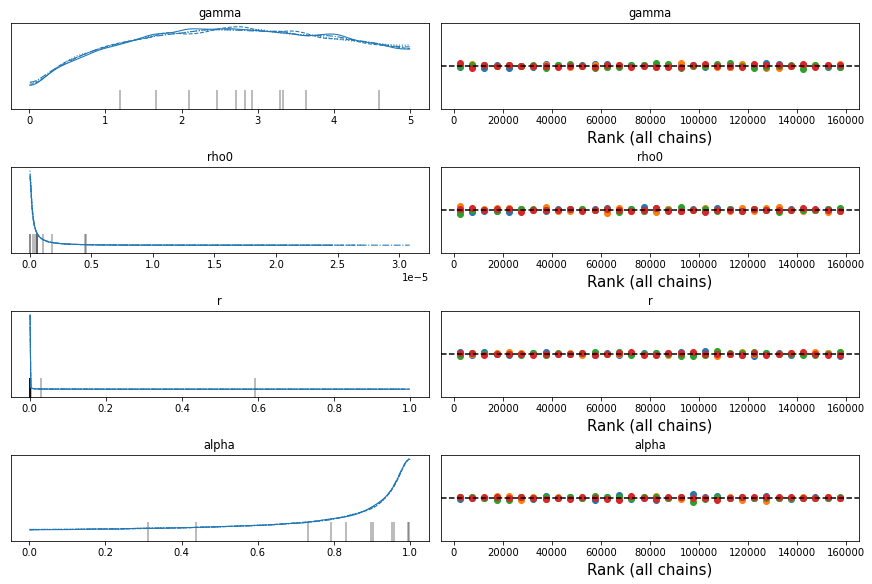

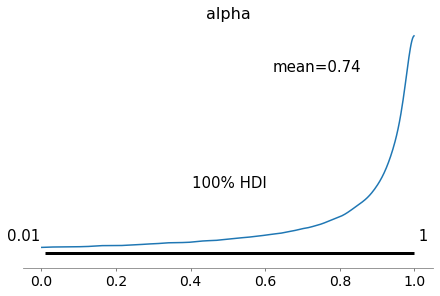

In [2]:
with pm.Model() as mm:
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    ur = pm.Uniform('ur', lower=-15, upper=0, testval=-3)
    r = pm.Deterministic('r', 10**(ur))
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    n1 = pm.Poisson.dist(mu=rho0*((s/s0)**(-gamma))*fov_tot)
    n2 = pm.Poisson.dist(
                    mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot
                   )
    n = pm.Mixture('n', w=[1-alpha, alpha], comp_dists=[n1, n2], observed=counts)
    trace_mm = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.9, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_mm, kind="rank_vlines", var_names=['gamma', 'rho0', 'r', 'alpha'])
    #az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_mm, var_names=['alpha'], hdi_prob=0.997)

In [3]:
import matplotlib
matplotlib.rc('text', usetex=False)

In [4]:
import matplotlib.pyplot as plt

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, u, g, alpha]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 85 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


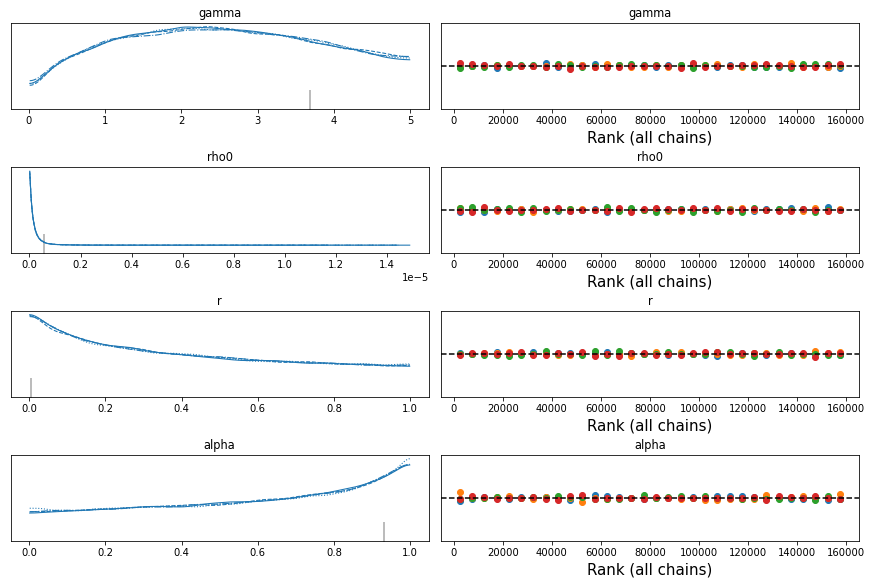

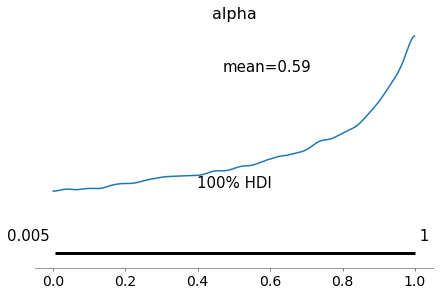

In [5]:
with pm.Model() as mm_unif:
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    r = pm.Uniform('r', lower=0, upper=1)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    n1 = pm.Poisson.dist(mu=rho0*((s/s0)**(-gamma))*fov_tot)
    n2 = pm.Poisson.dist(
                    mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot
                   )
    n = pm.Mixture('n', w=[1-alpha, alpha], comp_dists=[n1, n2], observed=counts)
    trace_unif = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.9, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_unif, kind="rank_vlines", var_names=['gamma', 'rho0', 'r', 'alpha'])
    #az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_unif, var_names=['alpha'], hdi_prob=0.997)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1/r, u, g, alpha]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 113 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


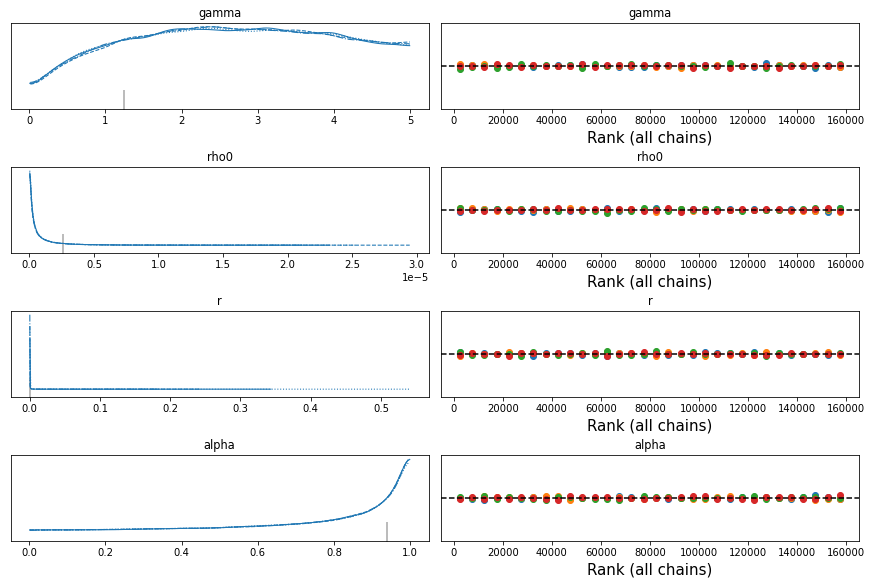

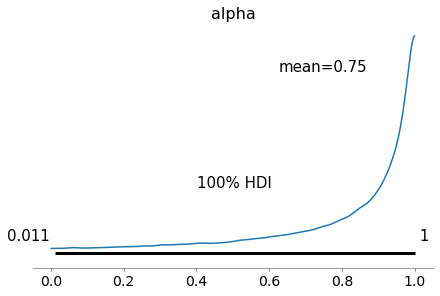

In [6]:
with pm.Model() as mm_one_over:
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    one_over_r = pm.Uniform('1/r', lower=1, upper=2e4)
    r = pm.Deterministic('r', 1/one_over_r)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    n1 = pm.Poisson.dist(mu=rho0*((s/s0)**(-gamma))*fov_tot)
    n2 = pm.Poisson.dist(
                    mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot
                   )
    n = pm.Mixture('n', w=[1-alpha, alpha], comp_dists=[n1, n2], observed=counts)
    trace_mm_one_over = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.95, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_mm_one_over, kind="rank_vlines", var_names=['gamma', 'rho0', 'r', 'alpha'])
    #az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_mm_one_over, var_names=['alpha'], hdi_prob=0.997)

# run everything again with a beta(0.5, 0.5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ur, u, g, alpha]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 145 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


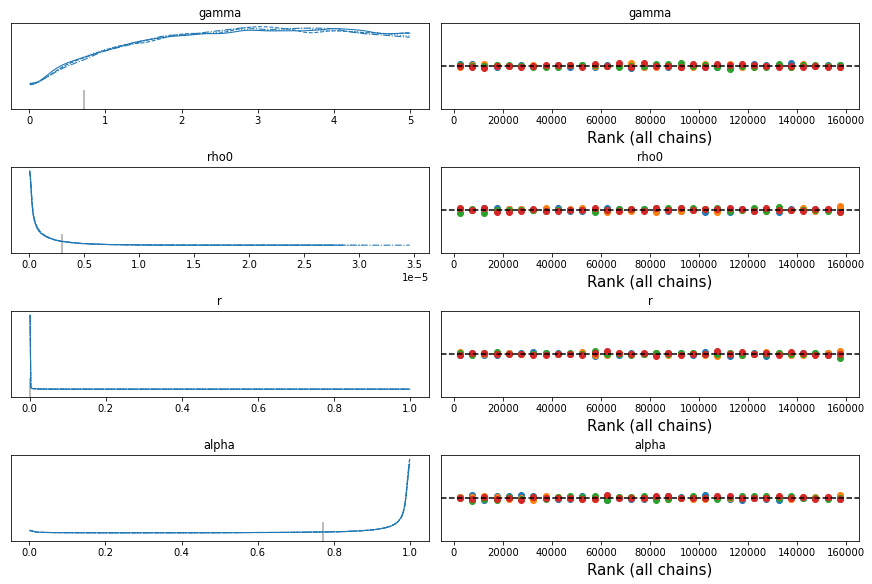

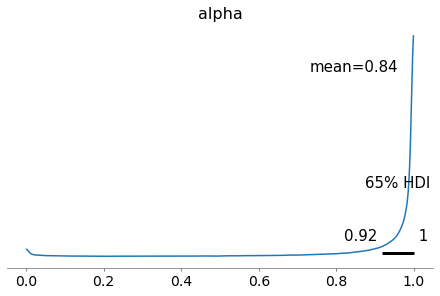

In [7]:
with pm.Model() as mm:
    alpha = pm.Beta('alpha', alpha=0.5, beta=0.5)
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    ur = pm.Uniform('ur', lower=-15, upper=0, testval=-3)
    r = pm.Deterministic('r', 10**(ur))
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    n1 = pm.Poisson.dist(mu=rho0*((s/s0)**(-gamma))*fov_tot)
    n2 = pm.Poisson.dist(
                    mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot
                   )
    n = pm.Mixture('n', w=[1-alpha, alpha], comp_dists=[n1, n2], observed=counts)
    trace_mm = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.97, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_mm, kind="rank_vlines", var_names=['gamma', 'rho0', 'r', 'alpha'])
    #az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_mm, var_names=['alpha'], hdi_prob=0.65)

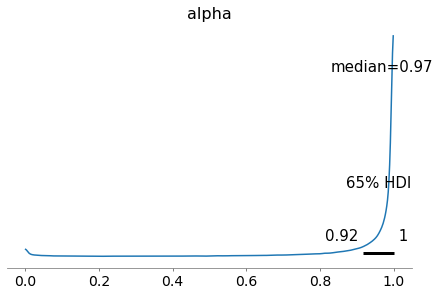

In [8]:
axs = az.plot_posterior(trace_mm, var_names=['alpha'], hdi_prob=0.65, point_estimate='median')

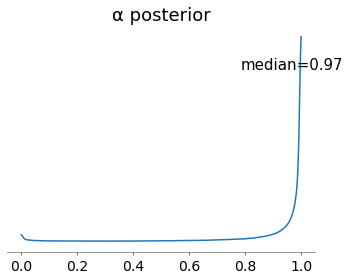

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
az.plot_posterior(trace_mm, var_names=['alpha'], hdi_prob='hide', ax=ax, point_estimate='median')
ax.set_title('α posterior', fontsize=18)
fig.tight_layout()
fig.savefig('/home/yuping/alpha-posterior.eps', bbox_inches = 'tight',pad_inches = 0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, u, g, alpha]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 153 seconds.


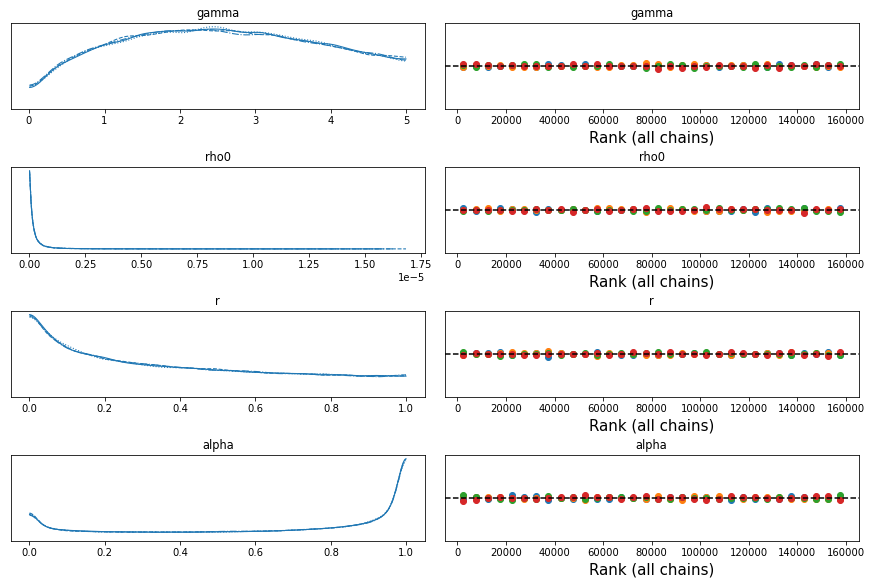

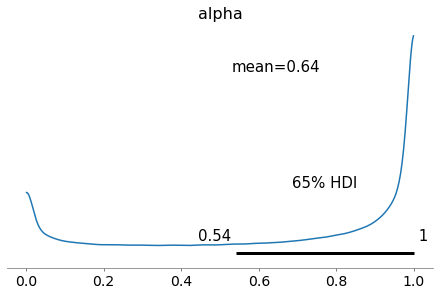

In [10]:
with pm.Model() as mm_unif:
    alpha = pm.Beta('alpha', alpha=0.5, beta=0.5)
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    r = pm.Uniform('r', lower=0, upper=1)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    n1 = pm.Poisson.dist(mu=rho0*((s/s0)**(-gamma))*fov_tot)
    n2 = pm.Poisson.dist(
                    mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot
                   )
    n = pm.Mixture('n', w=[1-alpha, alpha], comp_dists=[n1, n2], observed=counts)
    trace_unif = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.97, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_unif, kind="rank_vlines", var_names=['gamma', 'rho0', 'r', 'alpha'])
    #az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_unif, var_names=['alpha'], hdi_prob=0.65)

<AxesSubplot:title={'center':'alpha'}>

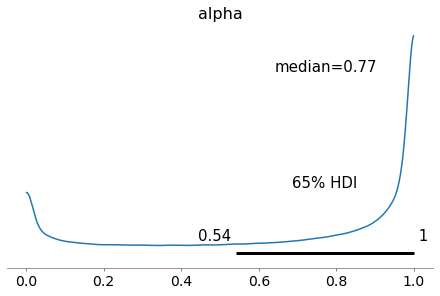

In [11]:
az.plot_posterior(trace_unif, var_names=['alpha'], hdi_prob=0.65, point_estimate='median')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1/r, u, g, alpha]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 136 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


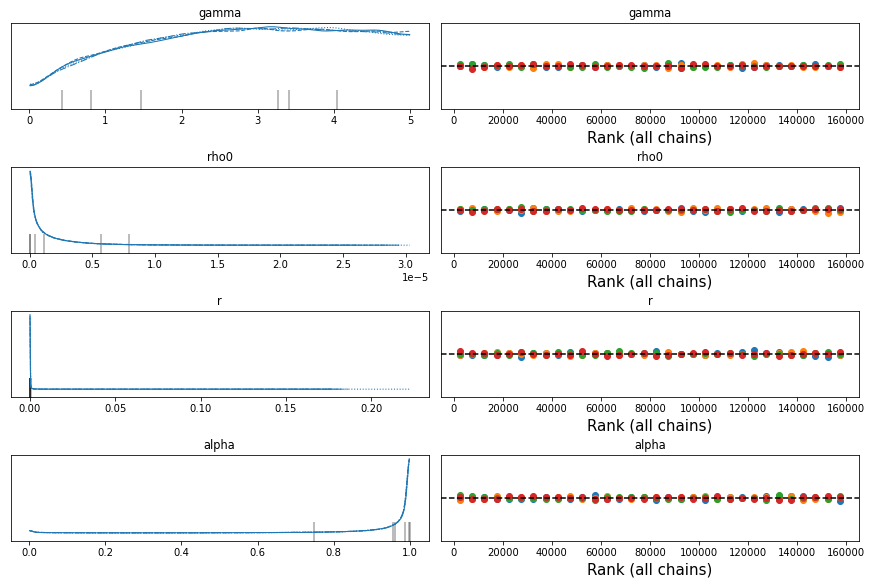

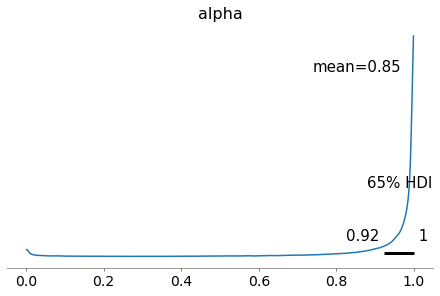

In [12]:
with pm.Model() as mm_one_over:
    alpha = pm.Beta('alpha', alpha=0.5, beta=0.5)
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    one_over_r = pm.Uniform('1/r', lower=1, upper=2e4)
    r = pm.Deterministic('r', 1/one_over_r)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    n1 = pm.Poisson.dist(mu=rho0*((s/s0)**(-gamma))*fov_tot)
    n2 = pm.Poisson.dist(
                    mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot
                   )
    n = pm.Mixture('n', w=[1-alpha, alpha], comp_dists=[n1, n2], observed=counts)
    trace_mm_one_over = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.96, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_mm_one_over, kind="rank_vlines", var_names=['gamma', 'rho0', 'r', 'alpha'])
    #az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_mm_one_over, var_names=['alpha'], hdi_prob=0.65)

<AxesSubplot:title={'center':'alpha'}>

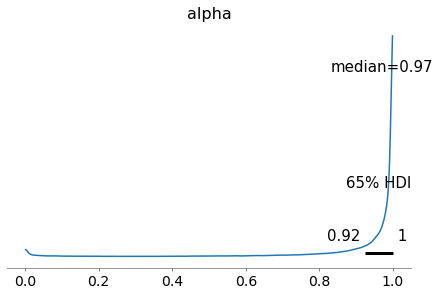

In [13]:
az.plot_posterior(trace_mm_one_over, var_names=['alpha'], hdi_prob=0.65, point_estimate='median')

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Sep 13 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

numpy     : 1.21.0
pymc3     : 3.11.2
astropy   : 4.2.1
matplotlib: 3.4.2
arviz     : 0.11.2

Watermark: 2.2.0

